# Demonstrace funkcionality balíčku `gradsolv`

### Import balíčků (včetně balíčku `gradsolv`)

In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import gradsolv as grad

### Deklarace řešičů, předpodmíňovačů a instance třídy `error_handle`

In [2]:
# Resice
solver_sd = grad.steepest_descend_solver() # Metoda nejvetsiho spadu
solver_cg = grad.conjugate_gradient_solver() # Metoda sdruzenych gradientu

# Predpodminovace
preconditioner_diag = grad.diagonal_preconditioner() # Diagonalni predpodminovac (M^(-1) = D^(-1))
preconditioner_gs_DLDLT = grad.gauss_seidel_DLDLT_preconditioner() # Gauss-Seidel predpodminovac (M^(-1) = (D + L/2)^(-1) * (D - L^(T)/2))
preconditioner_gs_LDDLD = grad.gauss_seidel_LDDLD_preconditioner() # Gauss-Seidel predpodminovac (M^(-1) = (L + D)^(-1) * D * (L + D)^(-T))

# error_handle (pomoci tohoto objektu (a funkce chkerr()) budeme odchytavat chyby, ktere by se mohly vyskytnout)
err_handle = grad.error_handle()

### Deklarace vektoru pravé strany

In [21]:
vec_b = np.array([18, 15, 2, 6, 18, 6, 7, 9, 7, 10], dtype=int)

### Cesta k testovacím datům

In [4]:
data_path = Path("./data/")

### Ukázka odchycení chyby a vyhození vyjímky

In [5]:
# Nacteni nesymetricke matice
mat_not_symmetric = np.load(data_path.joinpath("mat_not_symmetric.npy"))

print(mat_not_symmetric)

[[ 9  0  0  0  0  0  0  0  0  0]
 [ 1  6  0  0  0  0  0  0  0  0]
 [-3 -3  8  0  0  0  0  0  0  0]
 [-2 -5  4  9  0  0  0  0  0  0]
 [-5 -5  3  4  6  0  0  0  0  0]
 [ 1  2 -5 -5  2  6  0  0  0  0]
 [ 2 -2  0  3  4 -2  6  0  0  0]
 [-1 -4 -1  4  3 -5  1  9  0  0]
 [-5  0  3  1  3  2  3  1  9  0]
 [ 0  0 -3 -3  3  0 -5 -5 -1  7]]


In [6]:
result = solver_cg.solve(matrix=mat_not_symmetric, rhs=vec_b, err_handle=err_handle, tol=1e-8, max_it=10000, include_relres_vec=False)

# Vyhodi se vyjimka GradSolvError s prislusnou chybovou hlaskou
grad.chkerr(error_handle=err_handle)

GradSolvError: Matrix must be symmetric!

In [7]:
err_handle = grad.error_handle()

### Příklad č.1 (`mat_A`)

In [8]:
# Nacteni matice
mat_A = np.load(data_path.joinpath("mat_A.npy"))

print(mat_A)

[[2352    4    0    1    3   -5   -2    3   -3   -1]
 [   4 4463   -2   -2   -5    1   -5   -5   -3   -2]
 [   0   -2 2248    3    4    0   -5    0    2   -5]
 [   1   -2    3 3819   -3    0    3   -3   -3    1]
 [   3   -5    4   -3 2116    1    3   -1   -5   -4]
 [  -5    1    0    0    1 4344   -3   -4   -2   -3]
 [  -2   -5   -5    3    3   -3 1200    4   -4   -3]
 [   3   -5    0   -3   -1   -4    4 2221    0   -2]
 [  -3   -3    2   -3   -5   -2   -4    0 2743   -2]
 [  -1   -2   -5    1   -4   -3   -3   -2   -2 3206]]


#### Řešení soustavy s maticí `mat_A` pomocí metody největšího spádu (bez a s použitím daných předpodmíňovačů)

In [22]:
solver_sd.set_preconditioner(None)
result_sd_not_prec = solver_sd.solve(matrix=mat_A, rhs=vec_b, err_handle=err_handle, tol=1e-48, max_it=10000, include_relres_vec=True)

grad.chkerr(error_handle=err_handle)

print(f"Pocet iteraci: {result_sd_not_prec.iterations}")

Pocet iteraci: 192


In [23]:
solver_sd.set_preconditioner(preconditioner_diag)
result_sd_diag = solver_sd.solve(matrix=mat_A, rhs=vec_b, err_handle=err_handle, tol=1e-48, max_it=10000, include_relres_vec=True)

grad.chkerr(error_handle=err_handle)

print(f"Pocet iteraci: {result_sd_diag.iterations}")

Pocet iteraci: 22


In [24]:
solver_sd.set_preconditioner(preconditioner_gs_DLDLT)
result_sd_gs_DLDLT = solver_sd.solve(matrix=mat_A, rhs=vec_b, err_handle=err_handle, tol=1e-48, max_it=10000, include_relres_vec=True)

grad.chkerr(error_handle=err_handle)

print(f"Pocet iteraci: {result_sd_gs_DLDLT.iterations}")

Pocet iteraci: 182


In [25]:
solver_sd.set_preconditioner(preconditioner_gs_LDDLD)
result_sd_gs_LDDLD = solver_sd.solve(matrix=mat_A, rhs=vec_b, err_handle=err_handle, tol=1e-48, max_it=10000, include_relres_vec=True)

grad.chkerr(error_handle=err_handle)

print(f"Pocet iteraci: {result_sd_gs_LDDLD.iterations}")

Pocet iteraci: 10


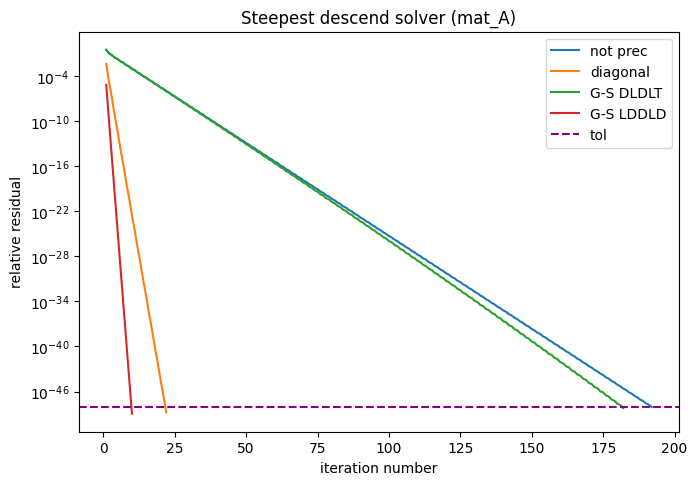

In [41]:
fig = plt.figure(figsize=(6,4))

ax = fig.add_axes([0,0,1,1])
ax.set_yscale("log")
ax.set_xlabel("iteration number")
ax.set_ylabel("relative residual")
ax.set_title("Steepest descend solver (mat_A)")

ax.plot(np.arange(1, result_sd_not_prec.relres_vec.shape[0] + 1), result_sd_not_prec.relres_vec, label="not prec")
ax.plot(np.arange(1, result_sd_diag.relres_vec.shape[0] + 1), result_sd_diag.relres_vec, label="diagonal")
ax.plot(np.arange(1, result_sd_gs_DLDLT.relres_vec.shape[0] + 1), result_sd_gs_DLDLT.relres_vec, label="G-S DLDLT")
ax.plot(np.arange(1, result_sd_gs_LDDLD.relres_vec.shape[0] + 1), result_sd_gs_LDDLD.relres_vec, label="G-S LDDLD")
ax.axhline(y=1e-48, color="purple", label="tol", linestyle="--")
ax.legend()

plt.show()

#### Řešení soustavy s maticí `mat_A` pomocí metody sdružených gradientů (bez a s použitím daných předpodmíňovačů)

In [28]:
solver_cg.set_preconditioner(None)
result_cg_not_prec = solver_cg.solve(matrix=mat_A, rhs=vec_b, err_handle=err_handle, tol=1e-48, max_it=10000, include_relres_vec=True)

grad.chkerr(error_handle=err_handle)

print(f"Pocet iteraci: {result_cg_not_prec.iterations}")

Pocet iteraci: 27


In [29]:
solver_cg.set_preconditioner(preconditioner_diag)
result_cg_diag = solver_cg.solve(matrix=mat_A, rhs=vec_b, err_handle=err_handle, tol=1e-48, max_it=10000, include_relres_vec=True)

grad.chkerr(error_handle=err_handle)

print(f"Pocet iteraci: {result_cg_diag.iterations}")

Pocet iteraci: 15


In [30]:
solver_cg.set_preconditioner(preconditioner_gs_DLDLT)
result_cg_gs_DLDLT = solver_cg.solve(matrix=mat_A, rhs=vec_b, err_handle=err_handle, tol=1e-48, max_it=10000, include_relres_vec=True)

grad.chkerr(error_handle=err_handle)

print(f"Pocet iteraci: {result_cg_gs_DLDLT.iterations}")

Pocet iteraci: 67


In [31]:
solver_cg.set_preconditioner(preconditioner_gs_LDDLD)
result_cg_gs_LDDLD = solver_cg.solve(matrix=mat_A, rhs=vec_b, err_handle=err_handle, tol=1e-48, max_it=10000, include_relres_vec=True)

grad.chkerr(error_handle=err_handle)

print(f"Pocet iteraci: {result_cg_gs_LDDLD.iterations}")

Pocet iteraci: 9


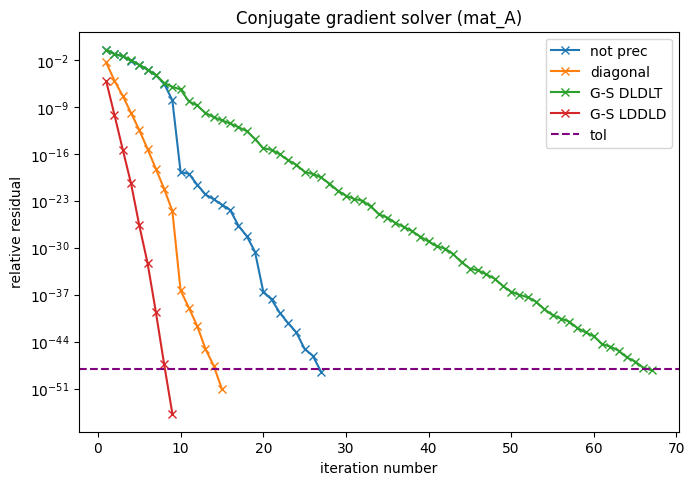

In [40]:
fig = plt.figure(figsize=(6,4))

ax = fig.add_axes([0,0,1,1])
ax.set_yscale("log")
ax.set_xlabel("iteration number")
ax.set_ylabel("relative residual")
ax.set_title("Conjugate gradient solver (mat_A)")

ax.plot(np.arange(1, result_cg_not_prec.relres_vec.shape[0] + 1), result_cg_not_prec.relres_vec, label="not prec", marker="x")
ax.plot(np.arange(1, result_cg_diag.relres_vec.shape[0] + 1), result_cg_diag.relres_vec, label="diagonal", marker="x")
ax.plot(np.arange(1, result_cg_gs_DLDLT.relres_vec.shape[0] + 1), result_cg_gs_DLDLT.relres_vec, label="G-S DLDLT", marker="x")
ax.plot(np.arange(1, result_cg_gs_LDDLD.relres_vec.shape[0] + 1), result_cg_gs_LDDLD.relres_vec, label="G-S LDDLD", marker="x")
ax.axhline(y=1e-48, color="purple", label="tol", linestyle="--")
ax.legend()

plt.show()